In [1]:
import numpy as np
import torch
from torch import nn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [2]:
import torchvision
from torchvision import models
from torchvision import transforms
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import models
from tqdm.auto import tqdm
torch.manual_seed(0)

# tensor -> PIL image
unloader = transforms.ToPILImage()

In [3]:
def show_tensor_images(batch_imgs):
    img = batch_imgs[0,]
    img = unloader(img)
    plt.imshow(img)
    plt.show()

In [4]:
class ToyDataset(Dataset):
    def __init__(self, dark_img_dir, light_img_dir):
        self.dark_img_dir = dark_img_dir
        self.light_img_dir = light_img_dir
        self.n_dark = len(os.listdir(self.dark_img_dir))
        self.n_light = len(os.listdir(self.light_img_dir))

    def __len__(self):     
        return min(self.n_dark, self.n_light)

    def __getitem__(self, idx):
        
        filename = os.listdir(self.light_img_dir)[idx]
        
        light_img_path = f"{self.light_img_dir}{filename}"
        light = Image.open(light_img_path).convert("RGB")
        
        dark_img_path = f"{self.dark_img_dir}{filename}"
        dark = Image.open(dark_img_path).convert("RGB")        
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        light = transform(light)
        dark = transform(dark)         

        return dark, light

batch_size = 1
    
val_dark_dir = f"./data_augment/test/dark/"
val_light_dir = f"./data_augment/test/light/"
validation_set = ToyDataset(val_dark_dir, val_light_dir)
validation_generator = DataLoader(validation_set, batch_size=batch_size)

In [5]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x],1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x
        
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)
    

In [6]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y],1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [7]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 50
input_dim = 3
real_dim = 3
display_step = 20
lr = 0.001


In [8]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

pretrained = True
if pretrained:
    loaded_state = torch.load("pix2pix_8500.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

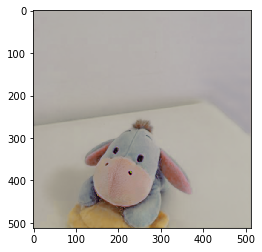

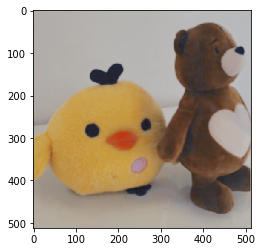

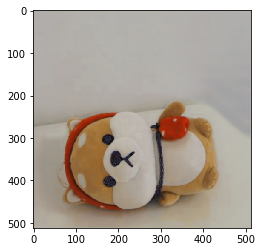

In [19]:
n  = 0
for dark, light in validation_generator:
    n += 1
    dark = dark.to(device)
    # torch.no_grad() only stops back probagation
    with torch.no_grad():
        fake = gen(dark)
    fake = fake.to("cpu")
    fake = unloader(fake[0,])
    plt.imshow(fake)
    plt.show()
    fake.save(f"./data_augment/test/gen/{n}.jpg")
    